In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cocpit.plotting_scripts import roc
import cocpit
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from cocpit import config as config
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc as plot_roc

In [3]:
plt_params = {
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.title_fontsize": 14,
    "legend.fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [39]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches

fold_max_preds = []
fold_topk_classes = []
fold_topk_probs = []
fold_labels = []

with torch.no_grad():
    for fold in range(config.KFOLD+1):
        print(fold)
        p = cocpit.predictions.LoaderPredictions()
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
        p.concatenate_loader_vars()
        fold_max_preds.append(p.max_preds)
        fold_topk_classes.append(p.topk_classes)
        fold_topk_probs.append(p.topk_probs)
        fold_labels.append([i.item() for i in p.labels])



0
1
2
3
4
5


In [40]:
# 1st and 5th fold have one more image
# truncate all vars to same length so we can reshape
# and add fold dimension
len_preds = [len(i) for i in fold_max_preds]
min_len = min(len_preds)

fold_max_preds = [i[:min_len] for i in fold_max_preds]
fold_topk_classes = [i[:min_len] for i in fold_topk_classes]
fold_topk_probs = [i[:min_len] for i in fold_topk_probs]
fold_labels = [i[:min_len] for i in fold_labels]

In [41]:
max_preds_rs = np.reshape(np.concatenate(fold_max_preds), (config.KFOLD+1, len(fold_max_preds[0])))
topk_classes_rs = np.reshape(np.concatenate(fold_topk_classes), (config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
topk_probs_rs = np.reshape(np.concatenate(fold_topk_probs), (config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
fold_labels_rs = np.reshape(np.concatenate(fold_labels), (config.KFOLD+1, len(fold_max_preds[0])))

In [49]:
# convert predictions into shape [fold, n_samples, n_classes]
# where predictions are in order of class number (0,1,2)
# not highest to lowest probability
yhat_proba = np.zeros((config.KFOLD+1, len(fold_max_preds[0]), len(config.CLASS_NAMES)))
for f in range(config.KFOLD+1):
    for i in range(len(fold_max_preds[0])):
        for c in range(len(config.CLASS_NAMES)):
            yhat_proba[f, i, c] = topk_probs_rs[f,i][np.where(topk_classes_rs[f,i] == c)[0][0]]


0 0 0 8806 8806
0 1 0 8806 8806
0 2 0 8806 8806
1 0 0 8806 8806
1 1 0 8806 8806
1 2 0 8806 8806
2 0 0 8806 8806
2 1 0 8806 8806
2 2 0 8806 8806
3 0 0 8806 8806
3 1 0 8806 8806
3 2 0 8806 8806
4 0 0 8806 8806
4 1 0 8806 8806
4 2 0 8806 8806
5 0 0 8806 8806
5 1 0 8806 8806
5 2 0 8806 8806
6 0 0 8806 8806
6 1 0 8806 8806
6 2 0 8806 8806
7 0 0 8806 8806
7 1 0 8806 8806
7 2 0 8806 8806
8 0 0 8806 8806
8 1 0 8806 8806
8 2 0 8806 8806
9 0 0 8806 8806
9 1 0 8806 8806
9 2 0 8806 8806
10 0 0 8806 8806
10 1 0 8806 8806
10 2 0 8806 8806
11 0 0 8806 8806
11 1 0 8806 8806
11 2 0 8806 8806
12 0 0 8806 8806
12 1 0 8806 8806
12 2 0 8806 8806
13 0 0 8806 8806
13 1 0 8806 8806
13 2 0 8806 8806
14 0 0 8806 8806
14 1 0 8806 8806
14 2 0 8806 8806
15 0 0 8806 8806
15 1 0 8806 8806
15 2 0 8806 8806
16 0 0 8806 8806
16 1 0 8806 8806
16 2 0 8806 8806
17 0 0 8806 8806
17 1 0 8806 8806
17 2 0 8806 8806
18 0 0 8806 8806
18 1 0 8806 8806
18 2 0 8806 8806
19 0 0 8806 8806
19 1 0 8806 8806
19 2 0 8806 8806
20 0 0 880

In [1]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
roc.peirce_contour(ax1)
roc.csi_contour(ax2)
roc.plot_frequency_bias(ax1)
roc.plot_frequency_bias(ax2)
roc.performance_diagram(ax1, ax2, fold_labels, yhat_proba)

NameError: name 'plt' is not defined

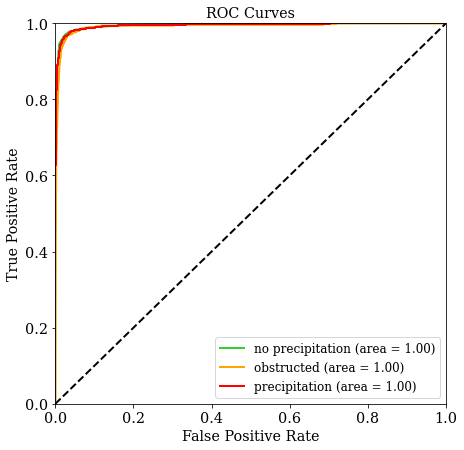

In [74]:
# confirm ROC curve is correct by plotting using sklearn
def calc_roc(labels, preds):
    """Compute Receiver operating characteristic (ROC)
    and area under curve (AUC) as if binary classification.
    Loop through each class to be used as positive label"""
    fpr, tpr, roc_auc = {}, {}, {}
    for i, c in enumerate(config.CLASS_NAMES):
        fpr[i], tpr[i], _ = roc_curve(labels, preds[:, i], pos_label=i)
        roc_auc = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def plot_roc(fpr, tpr, roc_auc):
    colors = ['limegreen', 'orange', 'r']
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    for i, c in enumerate(config.CLASS_NAMES):
        ax.plot(fpr[i], tpr[i], lw=2, color=colors[i],
                label=f'{c} (area = {1:0.2f})'
                        ''.format(c, roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title('ROC Curves')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

fpr, tpr, roc_auc = calc_roc([i.item() for i in p.labels], yhat_proba)
plot_roc(fpr, tpr, roc_auc)